# Example using an AmeriFlux site and the ``flux-data-qaqc`` Python module

This flux tower site is in Ohio near Lake Erie in a crop (wheat and soy) setting near a marsh. For more information on the site visit AmeriFlux here: [https://ameriflux.lbl.gov/sites/siteinfo/US-CRT#overview](https://ameriflux.lbl.gov/sites/siteinfo/US-CRT#overview)

The data file and the [``flux-data-qaqc``](https://flux-data-qaqc.readthedocs.io/en/latest/) configuration file has been included with this notebook so that the half-hourly data can be easily accessed. 

In [3]:
%matplotlib inline
import os

import numpy as np
import pandas as pd
import rasterio
import matplotlib.pyplot as plt
import pyproj
import pyproj as proj
from fluxdataqaqc import Data
from rasterio.plot import show

In [4]:

from micromet import volk as ffp


# Read in data using [``flux-data-qaqc``](https://flux-data-qaqc.readthedocs.io/en/latest/), resample to hourly 

Note that some wind variables are not excplicitly required by [``flux-data-qaqc``](https://flux-data-qaqc.readthedocs.io/en/latest/), i.e. not automatically referenced in the config and objects, to load them here we added the ``load_all_vars`` metadata option and refer to them by their respective names in the climate data file "AMF_US-CRT_BASE_HH_3-5.csv". In this case these variables are Monin-Obukhov length "MO_LENGTH", standard deviation of lateral velocity fluctuations "V_SIGMA", and friction velocity "USTAR". 

In [6]:
# load initial flux data 
d = Data('../Notebooks/Processing Workflow Notebooks/US-CRT_config.ini')
# adding variable names to Data instance name list for resampling
d.variables['MO_LENGTH'] = 'MO_LENGTH'
d.variables['USTAR'] = 'USTAR'
d.variables['V_SIGMA'] = 'V_SIGMA'
# renaming columns (optional and only affects windspeed and wind direction names)
df = d.df.rename(columns=d.inv_map)
#df = df.copy().loc['2024-07-03 00:00':]
df = df.resample('h').mean()
df.head()


,H,LE,G,wd,ws,USTAR,MO_LENGTH,V_SIGMA,t_avg,rh,Rn,sw_in,sw_out,lw_in,lw_out
date,,,,,,,,,,,,,,,
2011-01-01 00:00:00,NaN,NaN,27.185665,NaN,NaN,NaN,NaN,NaN,NaN,89.986134,4.719121,0.0,0.000000,367.15215,360.99875
2011-01-01 01:00:00,NaN,NaN,34.094585,NaN,NaN,NaN,NaN,NaN,NaN,81.941805,3.683791,0.0,2.467134,371.68190,366.80010
2011-01-01 02:00:00,-27.8487,NaN,29.311130,254.7010,3.11869,0.27374,69.337979,1.375590,11.8705,80.890344,4.630846,0.0,0.637368,373.68865,368.72525
2011-01-01 03:00:00,-29.3102,NaN,31.965615,232.3775,4.27658,0.27932,76.689723,0.979255,11.7439,91.686902,-0.379910,0.0,0.000000,368.10195,366.51695
2011-01-01 04:00:00,NaN,NaN,25.104715,NaN,NaN,NaN,NaN,NaN,NaN,92.091061,-0.645266,0.0,0.000000,364.97220,363.94450


In [7]:
df[['wd','ws','MO_LENGTH','USTAR','V_SIGMA']].head()

,wd,ws,MO_LENGTH,USTAR,V_SIGMA
date,,,,,
2011-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN
2011-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN
2011-01-01 02:00:00,254.7010,3.11869,69.337979,0.27374,1.375590
2011-01-01 03:00:00,232.3775,4.27658,76.689723,0.27932,0.979255
2011-01-01 04:00:00,NaN,NaN,NaN,NaN,NaN


# Convert station lat/lon to local UTM for georeferencing

This example converts the geographic coordinates to the local UTM zone and produces a raster image in that reprojected coordinate reference system. 

In [8]:
# get coords info from Data instance
latitude = d.latitude
longitude = d.longitude
station_coord = (latitude, longitude)
station = d.site_id

In [9]:
from pyproj import Transformer
EPSG = 5070
# Define the transformer from WGS84 to NAD83 Conus Albers
transformer = Transformer.from_crs("EPSG:4326", f"EPSG:{EPSG}", always_xy=True)

# Perform the transformation
station_x, station_y = transformer.transform(longitude, latitude)

print(f"Projected Coordinates in NAD83 Conus Albers (EPSG:5070): X={station_x}, Y={station_y}")


Projected Coordinates in NAD83 Conus Albers (EPSG:5070): X=1043351.7812768925, Y=2138906.4596680813


# Estimate remaining parameters and create daily footprint rasters with hourly footprints as bands

A few assumptions, the canopy height of 0.2 meters is constant, this site according to the owners is winter wheat and soybean rotation. Displacement height was not given but estimated for cropland as $d = 10^{0.979 \log_{10} hc - 0.154}$. Also, planetary boundary layer height was assigned as 2 km. Roughness length was also estimated as $0.123 h_c$. The footprints in this example are only calculated for hours between 7 AM and 8 PM, this alongwith footprint array domain, resolution, and other options are all easily adjustable using the arguments to the Kljun et al., (2015) footprint function. 

In [11]:
h_c = 0.2 #Height of canopy [m]
# Estimated displacement height [m]
d = 10**(0.979* np.log10(h_c) - 0.154)

# Produce a flux footprint for a single day

In [12]:
#Other model parameters
zm_s = 2 #Measurement height [m] from AMF metadata
h_s = 2000. #Height of atmos. boundary layer [m] - assumed
dx = 3. #Model resolution [m]
origin_d = 200. #Model bounds distance from origin [m]
# from 7 AM to 8 PM only, modify if needed
start_hr = 7
end_hr = 20
hours = np.arange(start_hr,end_hr+1)


#Loop through each day in the dataframe
for date in df.index.date:
    
    #Subset dataframe to only values in day of year
    print(f'Date: {date}')
    temp_df = df[df.index.date == date]
        
    new_dat = None
    
    for indx,t in enumerate(hours):
        
        band = indx + 1
        print(f'Hour: {t}')

        try:
            temp_line = temp_df.loc[temp_df.index.hour == t,:]
    
            #Calculate footprint
            temp_ffp = ffp.ffp_climatology(domain=[-origin_d,origin_d,-origin_d,origin_d],
                                           dx=dx,dy=dx,
                                    zm=zm_s-d, h=h_s, rs=None, z0=h_c*.123, 
                                    ol=temp_line['MO_LENGTH'].values,
                                           sigmav=temp_line['V_SIGMA'].values,
                                    ustar=temp_line['USTAR'].values, umean=temp_line['ws'].values,
                                    wind_dir=temp_line['wd'].values,
                                    crop=0,fig=0,
                                           verbosity=0)
            ####verbosoity=2 prints out errors; if z0 triggers errors, use umean
            #    print(zm_s-d)
    
            f_2d = np.array(temp_ffp['fclim_2d'])
            x_2d = np.array(temp_ffp['x_2d']) + station_x
            y_2d = np.array(temp_ffp['y_2d']) + station_y
            f_2d = f_2d*dx**2
    
            #Calculate affine transform for given x_2d and y_2d
            affine_transform = ffp.find_transform(x_2d,y_2d)
    
            #Create data file if not already created
            if new_dat is None:
                out_f = f'./{date}_{station}.tif'
                print(f_2d.shape)
                new_dat = rasterio.open(out_f,'w',driver='GTiff',dtype=rasterio.float64,
                                        count=len(hours),height=f_2d.shape[0],width=f_2d.shape[1],
                                        transform=affine_transform,
                                        crs=pyproj.crs.CRS.from_epsg(int(EPSG)),
                                        nodata=0.00000000e+000)
    
        except Exception as e:
            print(e)
            print(f'Hour {t} footprint failed, band {band} not written.')
    
            temp_ffp = None
    
            continue

        #Mask out points that are below a % threshold (defaults to 90%)
        f_2d = ffp.mask_fp_cutoff(f_2d)

        #Write the new band
        new_dat.write(f_2d,indx+1)

        #Update tags with metadata
        tag_dict = {'hour':f'{t*100:04}',
                    'wind_dir':temp_line['wd'].values,
                    'total_footprint':np.nansum(f_2d)}

        new_dat.update_tags(indx+1,**tag_dict)
    
    #Close dataset if it exists
    try:
        new_dat.close()
    except:
        continue
    
    print()
    
    # for esample just create a single day and exit
    break
    

2025-01-16 16:23:12,752 [DEBUG] micromet.volk:233: input len is 1

2025-01-16 16:23:12,754 [DEBUG] micromet.volk:273: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.276675])], [array([0.781285])], [2000.0], [array([96.31047893])], [array([228.464])], [np.float64(1.854886316642801)], [0.0246], [None]

2025-01-16 16:23:12,755 [INFO] micromet.volk:353: Domain: [-200.0, 200.0, -200.0, 200.0]

2025-01-16 16:23:12,756 [DEBUG] micromet.volk:377: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-16 16:23:12,759 [DEBUG] micromet.volk:400: x_2d: [[-200.         -196.9924812  -193.98496241 ...  193.98496241
   196.9924812   200.        ]
 [-200.         -196.9924812  -193.98496241 ...  193.98496241
   196.9924812   200.        ]
 [-200.         -196.9924812  -193.98496241 ...  193.98496241
   196.9924812   200.        ]
 ...
 [-200.         -196.9924812  -193.98496241 ...  193.98496241
   196.9924812   200.        ]
 [-200.         -196.99

Date: 2011-01-01
Hour: 7
(134, 134)
Hour: 8


2025-01-16 16:23:12,922 [DEBUG] micromet.volk:419: List of valids [True]

2025-01-16 16:23:12,923 [DEBUG] micromet.volk:436: valids of 0 are True

2025-01-16 16:23:12,925 [DEBUG] micromet.volk:447: rotated_theta: [[-6.3793704  -6.38694601 -6.39463639 ... -1.65171543 -1.65940581
  -1.66698142]
 [-6.37179479 -6.3793704  -6.38706256 ... -1.65928927 -1.66698142
  -1.67455703]
 [-6.36410441 -6.37167825 -6.3793704  ... -1.66698142 -1.67467358
  -1.68224741]
 ...
 [-4.82384007 -4.81626623 -4.80857408 ... -3.23777775 -3.23008559
  -3.22251176]
 [-4.81614969 -4.80857408 -4.80088192 ... -3.2454699  -3.23777775
  -3.23020214]
 [-4.80857408 -4.80099846 -4.79330809 ... -3.25304374 -3.24535336
  -3.23777775]]

2025-01-16 16:23:12,929 [DEBUG] micromet.volk:470: psi_f = [-0.09588327], zm = 1.854886316642801, ol = [102.5298546]

2025-01-16 16:23:12,930 [DEBUG] micromet.volk:473: Calculating xstar_ci_dummy...

2025-01-16 16:23:12,936 [DEBUG] micromet.volk:554: fclim_2d: [[1.29649779e-006 1.25291827e-006

Hour: 9
Hour: 10
Hour: 11
Hour: 12
cannot access local variable 'psi_f' where it is not associated with a value
Hour 12 footprint failed, band 6 not written.
Hour: 13


2025-01-16 16:23:13,146 [DEBUG] micromet.volk:79: mask_fp_cutoff: applied cutoff=0.9, sum_cutoff=6.436957787301526e-05

2025-01-16 16:23:13,149 [DEBUG] micromet.volk:233: input len is 1

2025-01-16 16:23:13,151 [DEBUG] micromet.volk:273: variables ustars, sigmavs, hs, ols, wind_dirs, zms, z0s, umeans input: [array([0.25404])], [array([1.00977])], [2000.0], [array([245.07389163])], [array([279.106])], [np.float64(1.854886316642801)], [0.0246], [None]

2025-01-16 16:23:13,152 [INFO] micromet.volk:353: Domain: [-200.0, 200.0, -200.0, 200.0]

2025-01-16 16:23:13,152 [DEBUG] micromet.volk:377: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-16 16:23:13,155 [DEBUG] micromet.volk:400: x_2d: [[-200.         -196.9924812  -193.98496241 ...  193.98496241
   196.9924812   200.        ]
 [-200.         -196.9924812  -193.98496241 ...  193.98496241
   196.9924812   200.        ]
 [-200.         -196.9924812  -193.98496241 ...  193.98496241
   196.9924812   200.        ]
 .

Hour: 14
Hour: 15
cannot access local variable 'psi_f' where it is not associated with a value
Hour 15 footprint failed, band 9 not written.
Hour: 16
cannot access local variable 'psi_f' where it is not associated with a value
Hour 16 footprint failed, band 10 not written.
Hour: 17
cannot access local variable 'psi_f' where it is not associated with a value
Hour 17 footprint failed, band 11 not written.
Hour: 18
Hour: 19
Hour: 20


2025-01-16 16:23:13,326 [INFO] micromet.volk:353: Domain: [-200.0, 200.0, -200.0, 200.0]

2025-01-16 16:23:13,327 [DEBUG] micromet.volk:377: parameters rslayer, smooth_data, crop, pulse, fig: 0, 1, 0, 1, 0

2025-01-16 16:23:13,329 [DEBUG] micromet.volk:400: x_2d: [[-200.         -196.9924812  -193.98496241 ...  193.98496241
   196.9924812   200.        ]
 [-200.         -196.9924812  -193.98496241 ...  193.98496241
   196.9924812   200.        ]
 [-200.         -196.9924812  -193.98496241 ...  193.98496241
   196.9924812   200.        ]
 ...
 [-200.         -196.9924812  -193.98496241 ...  193.98496241
   196.9924812   200.        ]
 [-200.         -196.9924812  -193.98496241 ...  193.98496241
   196.9924812   200.        ]
 [-200.         -196.9924812  -193.98496241 ...  193.98496241
   196.9924812   200.        ]], y_2d: [[-200.         -200.         -200.         ... -200.
  -200.         -200.        ]
 [-196.9924812  -196.9924812  -196.9924812  ... -196.9924812
  -196.9924812  -19

# View footprint raster

First plot shows georeferenced (UTM zone 17) footprint (first bad at 7:00 AM) and the plot below shows a different hour, the third plot shows the daily average using matplotlib. Not the second two plots are not georefenced and the axes are in pixel count.

In [26]:
station_x, station_y

(1043351.7812768925, 2138906.4596680813)

In [43]:
array.shape

(134, 134)

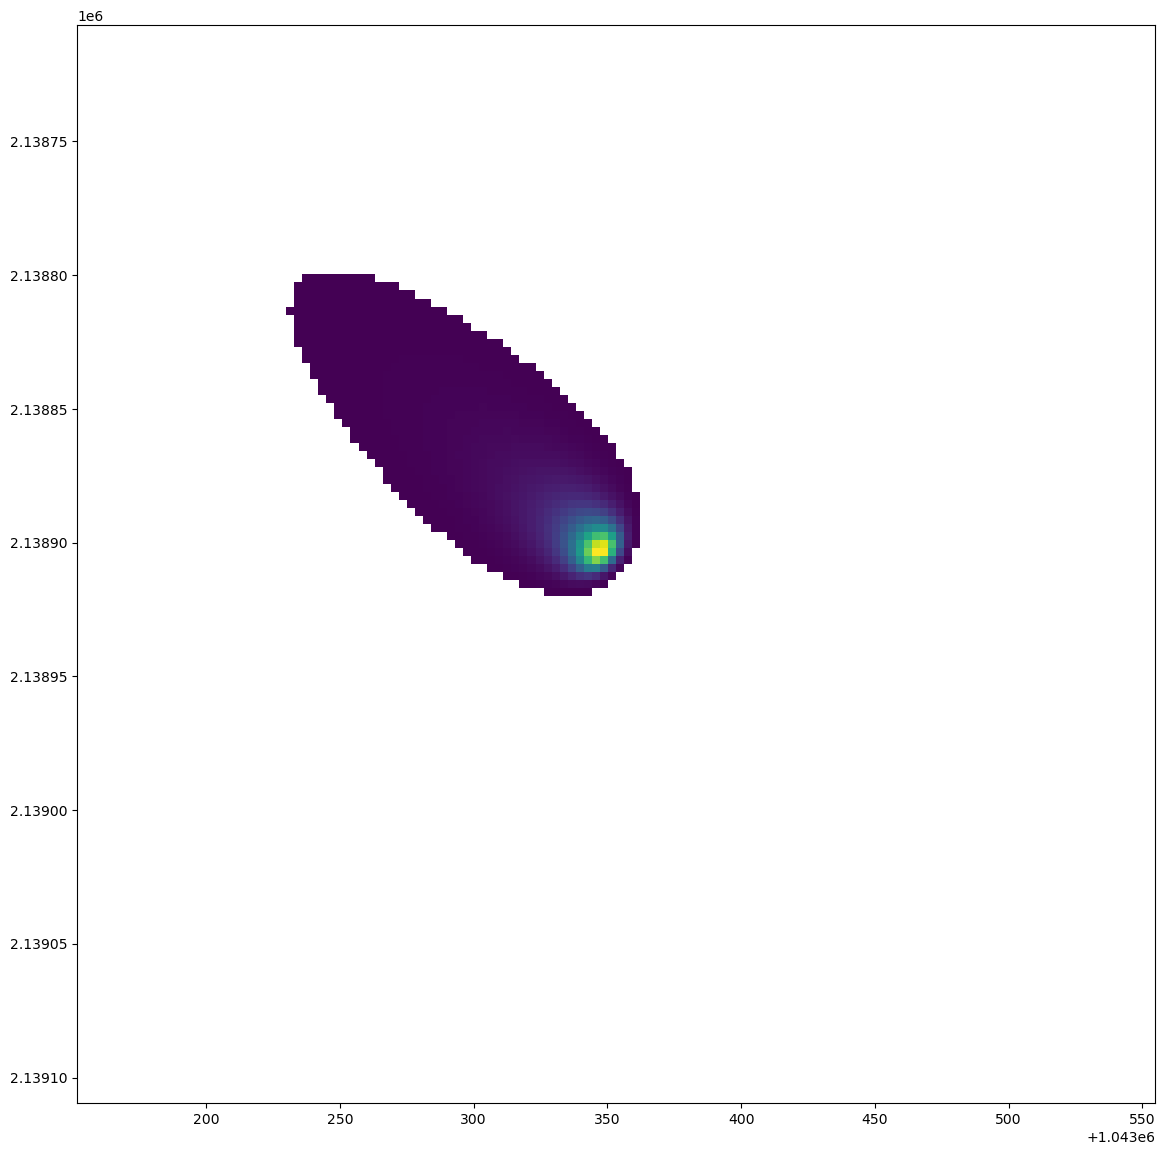

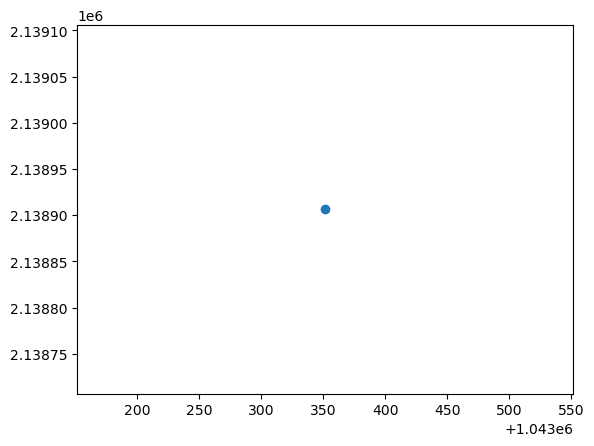

In [46]:
from rasterio.plot import show_hist

#plt.figure(figsize=(14,14))
fig, ax = plt.subplots(figsize=(14,14))
src = rasterio.open("2011-01-01_US-CRT.tif")
array = src.read(1)
show(src)
#show(src)
plt.scatter(station_x, station_y)
plt.xlim(station_x-200,station_x+200)
plt.ylim(station_y-200,station_y+200)
plt.show()

In [23]:
temp_df

,H,LE,G,wd,ws,USTAR,MO_LENGTH,V_SIGMA,t_avg,rh,Rn,sw_in,sw_out,lw_in,lw_out
date,,,,,,,,,,,,,,,
2011-01-01 00:00:00,NaN,NaN,27.185665,NaN,NaN,NaN,NaN,NaN,NaN,89.986134,4.719121,0.000000,0.000000,367.15215,360.99875
2011-01-01 01:00:00,NaN,NaN,34.094585,NaN,NaN,NaN,NaN,NaN,NaN,81.941805,3.683791,0.000000,2.467134,371.68190,366.80010
2011-01-01 02:00:00,-27.848700,NaN,29.311130,254.7010,3.118690,0.273740,69.337979,1.375590,11.87050,80.890344,4.630846,0.000000,0.637368,373.68865,368.72525
2011-01-01 03:00:00,-29.310200,NaN,31.965615,232.3775,4.276580,0.279320,76.689723,0.979255,11.74390,91.686902,-0.379910,0.000000,0.000000,368.10195,366.51695
2011-01-01 04:00:00,NaN,NaN,25.104715,NaN,NaN,NaN,NaN,NaN,NaN,92.091061,-0.645266,0.000000,0.000000,364.97220,363.94450
2011-01-01 05:00:00,NaN,NaN,27.687355,NaN,NaN,NaN,NaN,NaN,NaN,94.389405,0.190975,0.000000,0.000000,366.36020,364.90830
2011-01-01 06:00:00,-18.546400,NaN,29.671945,228.7670,5.564490,0.283070,114.829775,0.841930,11.05010,95.117556,0.853545,0.000000,0.000000,368.78965,366.88795
2011-01-01 07:00:00,-19.526550,-16.133608,25.487340,228.4640,5.148170,0.276675,96.310479,0.781285,11.42770,95.214756,-1.419721,0.000000,0.000000,366.86950,367.03125
2011-01-01 08:00:00,-26.956050,NaN,25.750240,230.5110,5.244335,0.304205,102.529855,0.799765,11.24610,94.909368,-0.138674,1.543985,0.540544,366.11435,367.17965


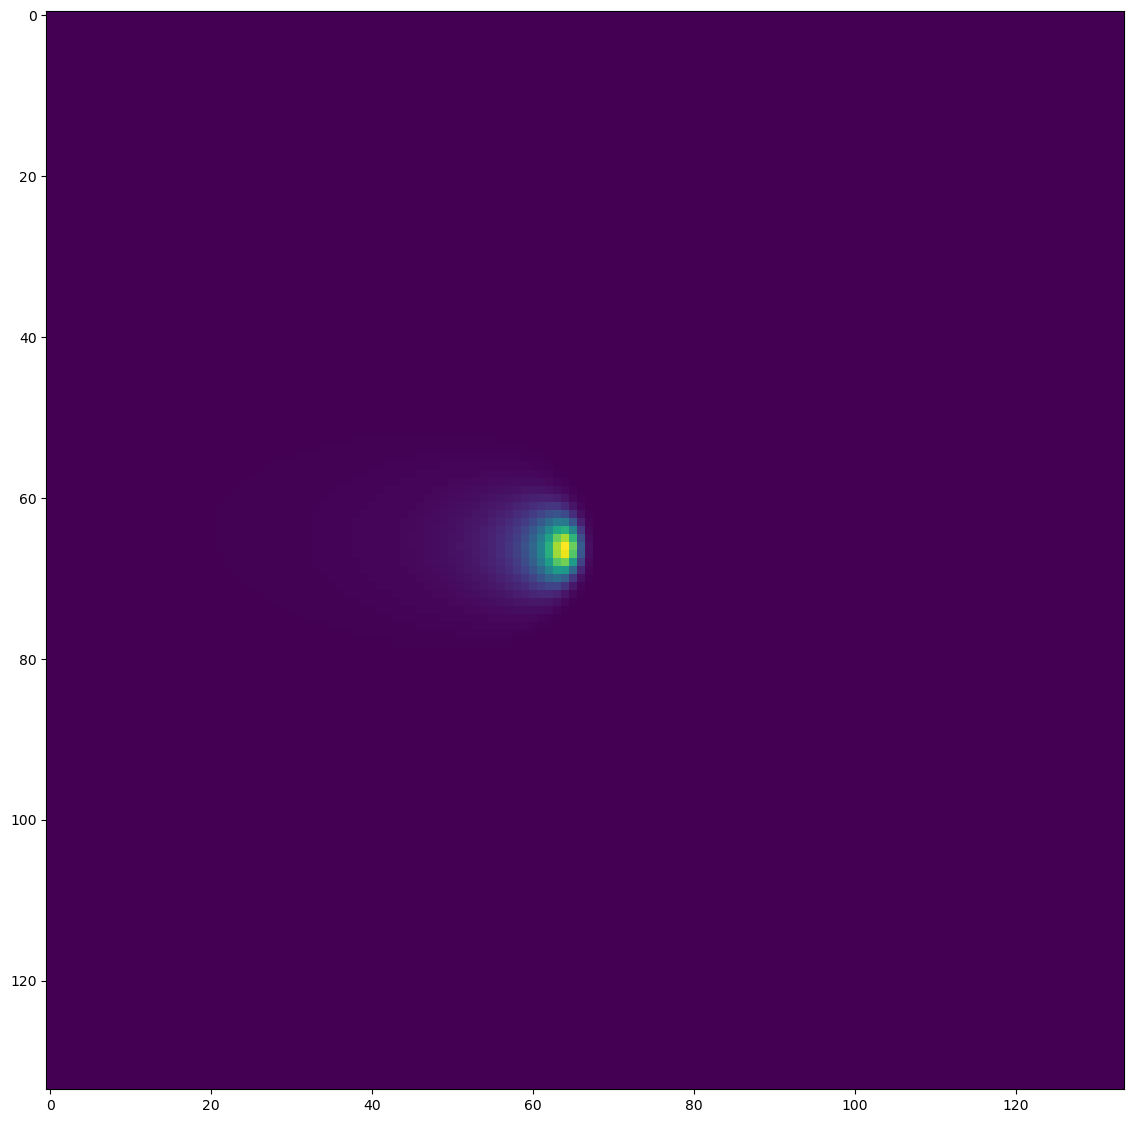

<Axes: >

In [22]:
# view a band for the hour of 10:00 AM (4th band)
plt.figure(figsize=(14,14))
src = rasterio.open("../../footprints/data/2011-01-01_US-CRT.tif")
show(src.read(4))